In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.graph_objects as pgo
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima

import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

warnings.simplefilter('ignore', ValueWarning)

d:\users\User\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [4]:
from prophet import Prophet

Overview

In [5]:
df = pd.read_csv('STOCK_TSLA.csv')
df.head(15)

,Date,Close/Last,Volume,Open,High,Low
0,06/27/2025,$323.63,89067050,$324.51,$329.3393,$317.495
1,06/26/2025,$325.78,80440910,$324.61,$331.05,$323.61
2,06/25/2025,$327.55,119845100,$342.70,$343.00,$320.40
3,06/24/2025,$340.47,114736200,$356.17,$356.26,$340.44
4,06/23/2025,$348.68,190716800,$327.54,$357.54,$327.48
5,06/20/2025,$322.16,108688000,$327.95,$332.36,$317.78
6,06/18/2025,$322.05,95137690,$317.31,$329.32,$315.45
7,06/17/2025,$316.35,88282670,$326.09,$327.26,$314.74
8,06/16/2025,$329.13,83925860,$331.29,$332.05,$326.41
9,06/13/2025,$325.31,128964300,$313.97,$332.99,$313.30


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        1255 non-null   object
 1   Close/Last  1255 non-null   object
 2   Volume      1255 non-null   int64 
 3   Open        1255 non-null   object
 4   High        1255 non-null   object
 5   Low         1255 non-null   object
dtypes: int64(1), object(5)
memory usage: 59.0+ KB
None


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [8]:
print(df['Close/Last'].head(10))
print(df['Close/Last'].apply(type).value_counts())


Date
2025-06-27    $323.63
2025-06-26    $325.78
2025-06-25    $327.55
2025-06-24    $340.47
2025-06-23    $348.68
2025-06-20    $322.16
2025-06-18    $322.05
2025-06-17    $316.35
2025-06-16    $329.13
2025-06-13    $325.31
Name: Close/Last, dtype: object
Close/Last
<class 'str'>    1255
Name: count, dtype: int64


In [9]:
def clean_convert_cols(df, columns):
    for col in columns:
        df[col] = (df[col].str.replace('$', '', regex=False).astype(float).round().astype('Int64'))
    return df

cols = ['Close/Last', 'Open', 'High', 'Low']
df = clean_convert_cols(df, cols)

In [10]:
print(df[cols].dtypes)
print(df[cols].head())


Close/Last    Int64
Open          Int64
High          Int64
Low           Int64
dtype: object
            Close/Last  Open  High  Low
Date                                   
2025-06-27         324   325   329  317
2025-06-26         326   325   331  324
2025-06-25         328   343   343  320
2025-06-24         340   356   356  340
2025-06-23         349   328   358  327


In [11]:
df.isna().sum()

Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [12]:
df.drop_duplicates(inplace=True)

Time Series Visualization

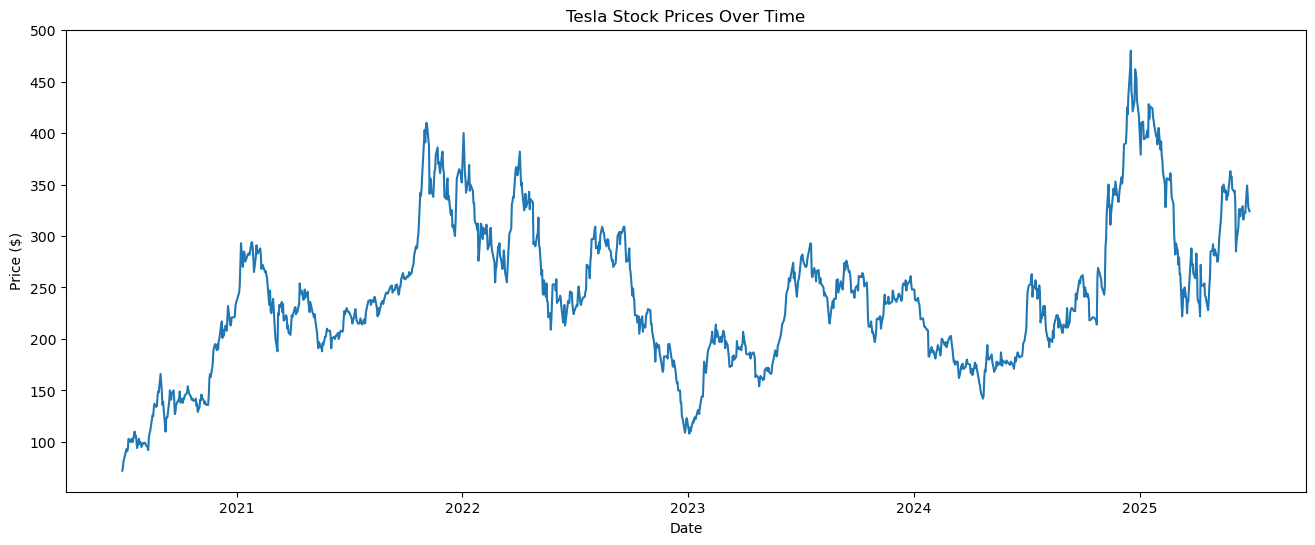

In [13]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Close/Last'], label='Tesla Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('Tesla Stock Prices Over Time')
plt.show()

Analyzing Trend using Simple Moving Average (50, 200 days)

In the year of 2023 Stock Prices have decreased; 

since the mid of 2023 to early 2024 Prices fluctuated without any sharp changes; 

in the middle of 2024 there is a sharp increase in Stock Prices

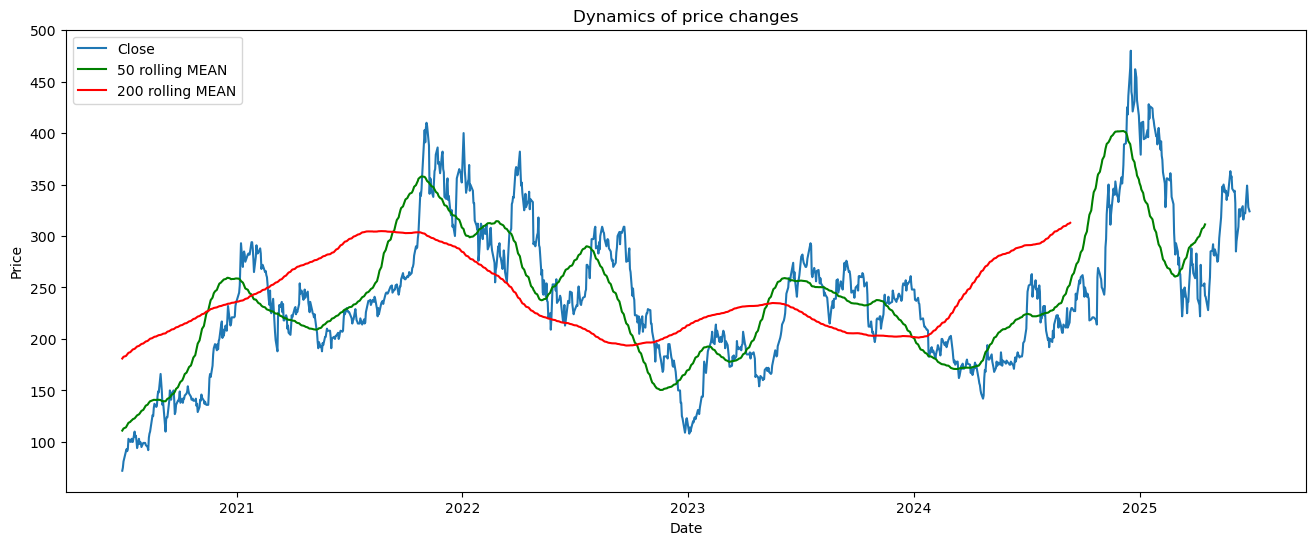

In [14]:
#rolling mean 
df['SMA_50'] = df['Close/Last'].rolling(window=50).mean()
df['SMA_100'] = df['Close/Last'].rolling(window=200).mean()

plt.figure(figsize=(16, 6))
plt.plot(df['Close/Last'], label='Close')
plt.plot(df['SMA_50'], label='50 rolling MEAN', color='green')
plt.plot(df['SMA_100'], label='200 rolling MEAN', color='red')

plt.title('Dynamics of price changes') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

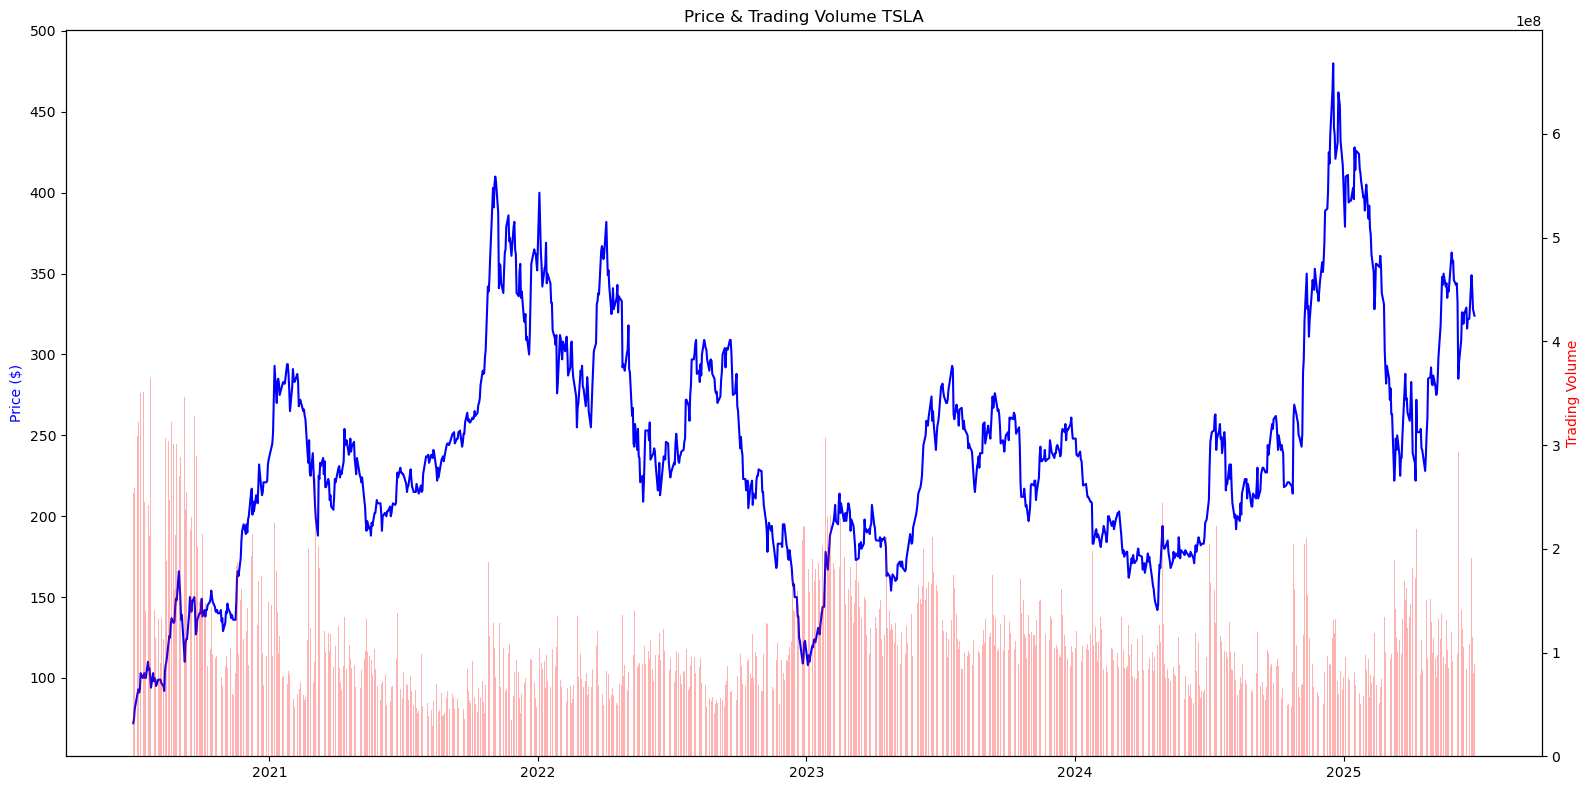

In [15]:
#trading volume 
fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(df.index, df['Close/Last'], label='Close Price', color='blue')
ax1.set_ylabel('Price ($)', color='blue')

ax2 = ax1.twinx()
ax2.bar(df.index, df['Volume'], alpha=0.3, color='red', label='Volume')
ax2.set_ylabel('Trading Volume', color='red')

plt.title('Price & Trading Volume TSLA')
fig.tight_layout()
plt.show()


Creating an Interactive Boxplot for better understanding 

In [16]:
df['Month'] = df.index.to_period('M').astype(str)
ordered_M = sorted(df['Month'].unique(), key=lambda x: pd.Period(x))
monthly_avg = df.groupby('Month')['Close/Last'].mean().reindex(ordered_M)

box_traces = []
for m in ordered_M: 
     val = df[df['Month'] == m][['Close/Last']]
     box_traces.append((pgo.Box(
          y=val, name=m, boxpoints='outliers', marker_color='lightsteelblue', line=dict(color='blue')
     )))


line_trace = pgo.Scatter(
    x=ordered_M, y=monthly_avg.values, mode='lines+markers', name='Mean Price', line=dict(color='red', width=1)
)

fig = pgo.Figure(data=box_traces + [line_trace])
fig.update_layout(
    title='Boxplot TSLA',
    xaxis_title='Month',
    yaxis_title='Price ($)',
    template='plotly_white',
    hovermode='x unified'
)

fig.show()



Analyzing Volume & Price using ScatterPlot

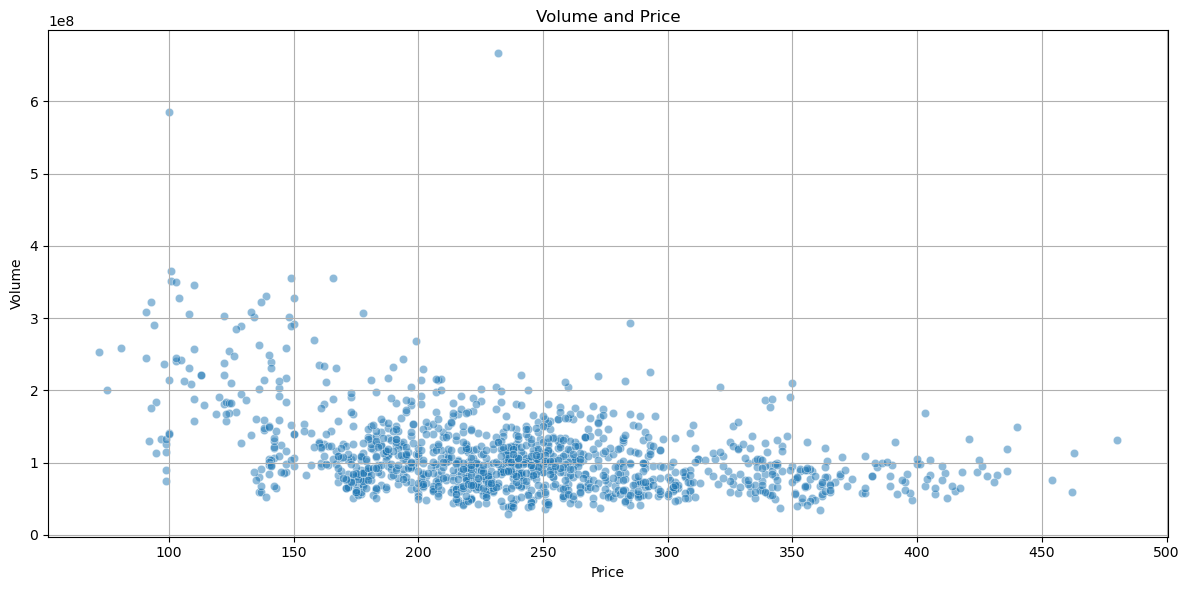

In [17]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Close/Last', y='Volume', alpha=0.5)
plt.title('Volume and Price')
plt.xlabel('Price')
plt.ylabel('Volume')
plt.grid(True)
plt.tight_layout()
plt.show()


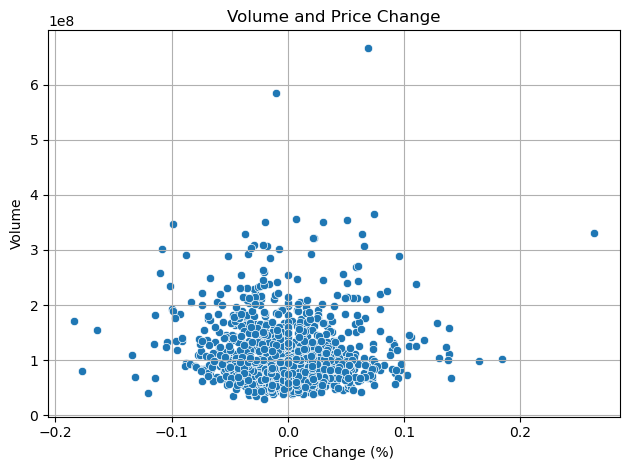

In [18]:
df['Price_Change'] = df['Close/Last'].pct_change().astype(float) #pct_change calculates the percentage change between the current and previous element

sns.scatterplot(data=df, x='Price_Change', y='Volume')
plt.title('Volume and Price Change')
plt.xlabel('Price Change (%)')
plt.ylabel('Volume')
plt.grid(True)
plt.tight_layout()
plt.show()


Correlation and Seasonality

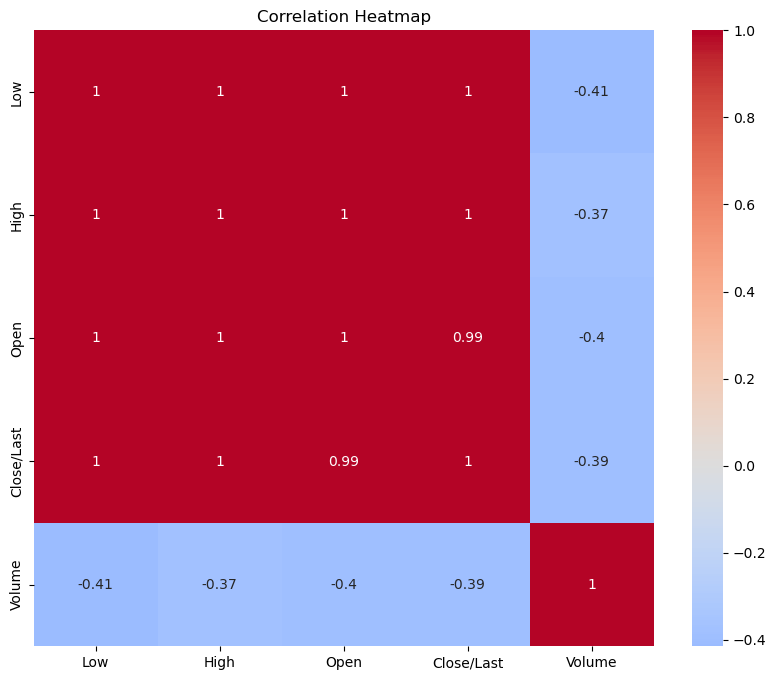

In [19]:
cols = ['Low', 'High', 'Open', 'Close/Last', 'Volume']
corr_matrix = df[cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()




Volume has negative correlation with others. It means, when price increases, volume decreases (shows here: Price & Trading Volume TSLA). 
So checking Volume on Weekdays

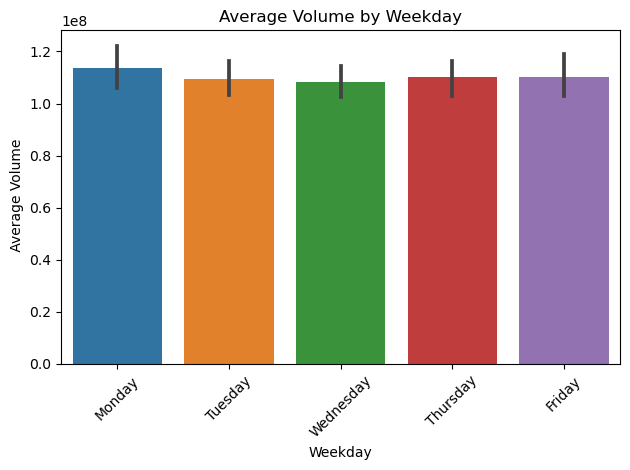

In [20]:
df['Weekday'] = df.index.dayofweek
df['Weekday'] = df['Weekday'].apply(lambda x: calendar.day_name[x])

sns.barplot(x='Weekday', y='Volume', data=df, estimator='mean', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])
plt.title('Average Volume by Weekday')
plt.xlabel('Weekday')
plt.ylabel(' Average Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The Volume is steady across the days of the week. It means that volumes may be influenced by external factors (news etc).
Let's check Trends, Seasonality, Residual

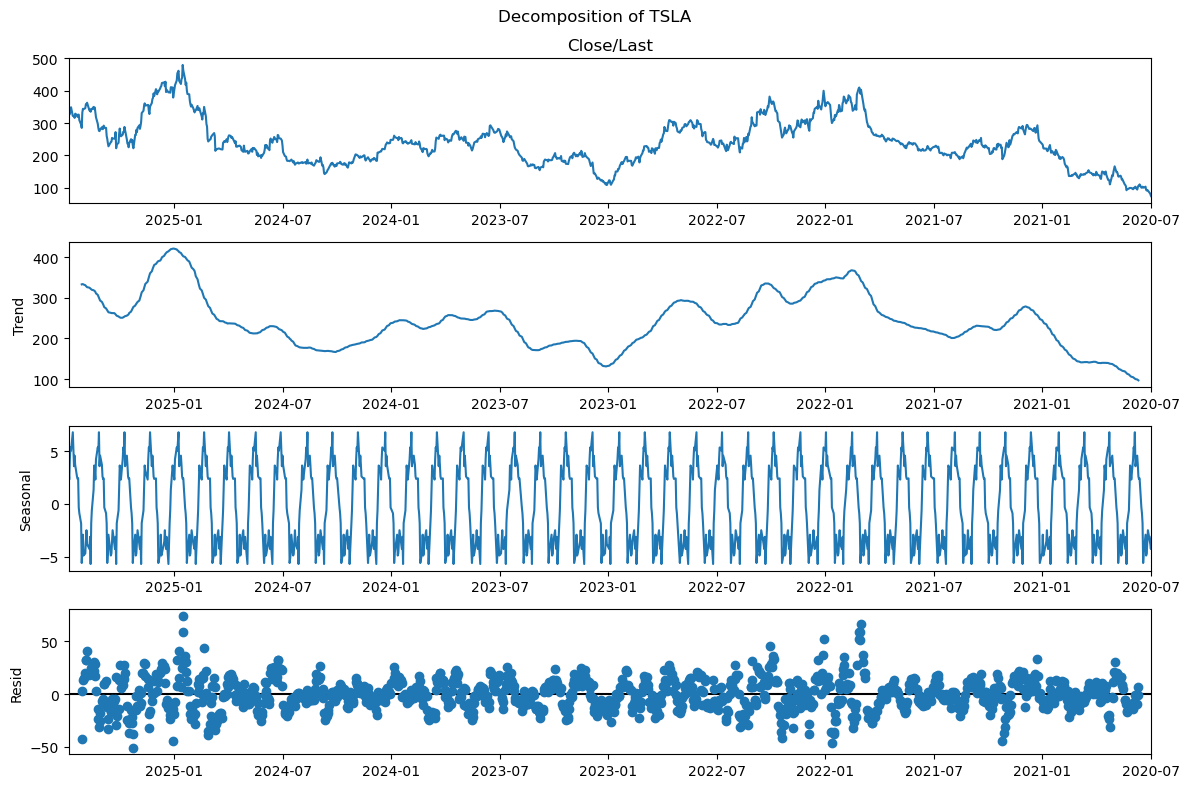

In [21]:
df['Close/Last'] = df['Close/Last'].interpolate()

result = seasonal_decompose(df['Close/Last'], model='additive', period=30)
fig = result.plot()
fig.set_size_inches(12, 8)

plt.suptitle('Decomposition of TSLA')
plt.tight_layout()
plt.show()


Trend visually smooths the real data; seasonality graph in the form of a cosine (no depence on price level). Let's check the residuals

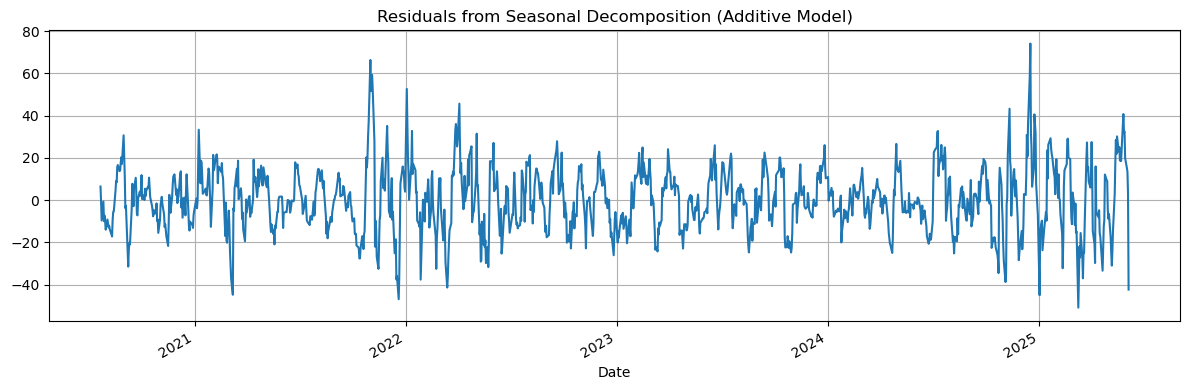

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))
result.resid.plot(ax=ax)
ax.set_title('Residuals from Seasonal Decomposition (Additive Model)')
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='Date'>

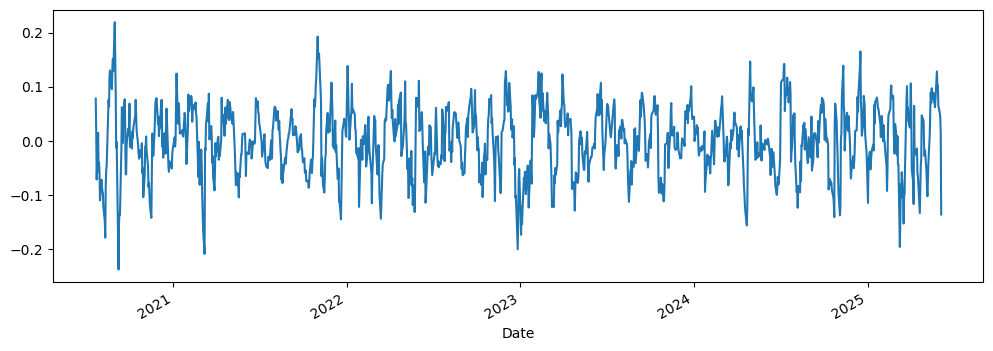

In [23]:
df['CLose/Last_log'] = np.log(df['Close/Last'])
result = seasonal_decompose(df['CLose/Last_log'], model='additive', period=30)
result.resid.plot(figsize=(12, 4))

<Axes: >

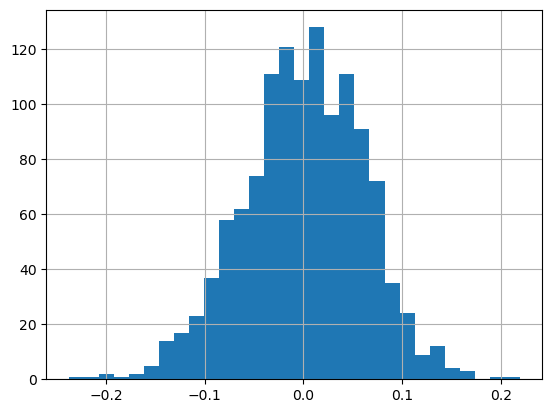

In [24]:
result.resid.dropna().hist(bins=30)

In [25]:
df.head(10)

,Close/Last,Volume,Open,High,Low,SMA_50,SMA_100,Month,Price_Change,Weekday,CLose/Last_log
Date,,,,,,,,,,,
2025-06-27,324.0,89067050,325,329,317,NaN,NaN,2025-06,NaN,Friday,5.780744
2025-06-26,326.0,80440910,325,331,324,NaN,NaN,2025-06,0.006173,Thursday,5.786897
2025-06-25,328.0,119845100,343,343,320,NaN,NaN,2025-06,0.006135,Wednesday,5.793014
2025-06-24,340.0,114736200,356,356,340,NaN,NaN,2025-06,0.036585,Tuesday,5.828946
2025-06-23,349.0,190716800,328,358,327,NaN,NaN,2025-06,0.026471,Monday,5.855072
2025-06-20,322.0,108688000,328,332,318,NaN,NaN,2025-06,-0.077364,Friday,5.774552
2025-06-18,322.0,95137690,317,329,315,NaN,NaN,2025-06,0.000000,Wednesday,5.774552
2025-06-17,316.0,88282670,326,327,315,NaN,NaN,2025-06,-0.018634,Tuesday,5.755742
2025-06-16,329.0,83925860,331,332,326,NaN,NaN,2025-06,0.041139,Monday,5.796058


Creating a Base Model using Prophet. As we have strong Yearly Seasonality (cosine). It might be useful for forecasting sales as TSLA stocks. Also it is robust to Outliers & Missing Values. 

21:23:41 - cmdstanpy - INFO - Chain [1] start processing
21:23:42 - cmdstanpy - INFO - Chain [1] done processing


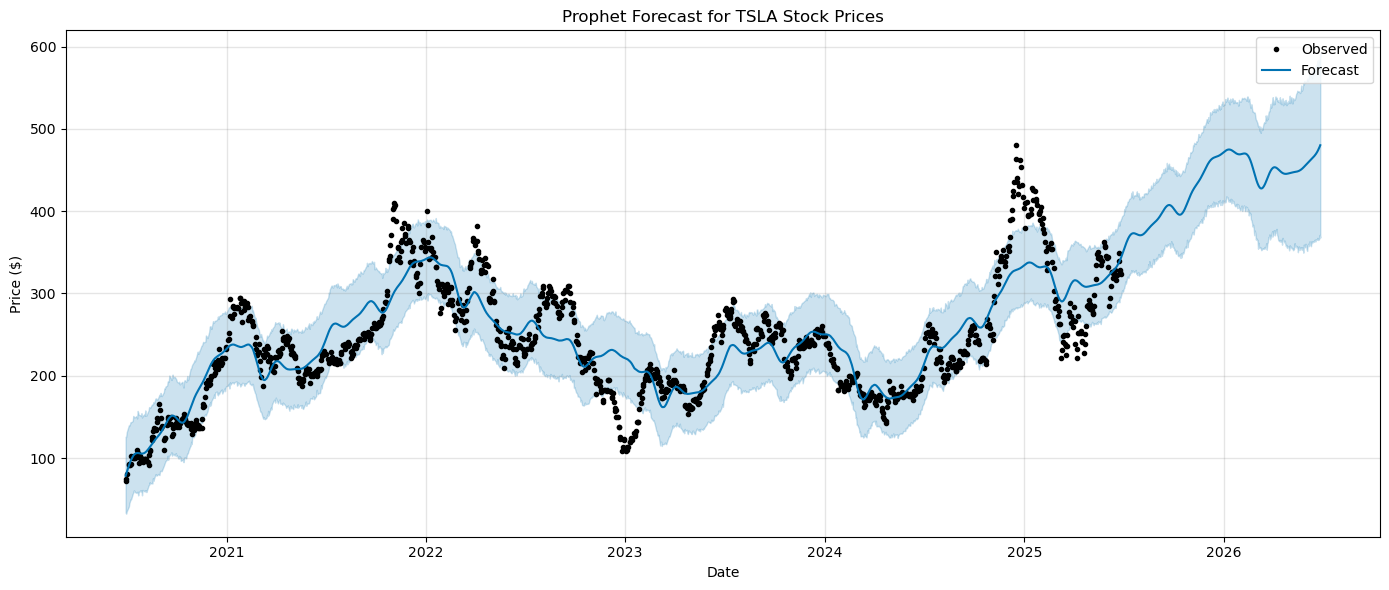

In [26]:
df_prophet = df.reset_index()[['Date', 'Close/Last']]
df_prophet.columns = ['ds', 'y'] 

model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=365) #forecast for the next year
forecast = model.predict(future)

fig = model.plot(forecast)
fig.set_size_inches(14, 6)

ax = fig.gca()
ax.legend(['Observed', 'Forecast'])
ax.set_title('Prophet Forecast for TSLA Stock Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')
plt.tight_layout()
plt.show()

In [27]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1615,2026-06-23,474.036217,364.918035,575.432132
1616,2026-06-24,475.411419,365.321108,583.655018
1617,2026-06-25,476.881616,366.225415,581.022095
1618,2026-06-26,478.443596,371.316435,584.576566
1619,2026-06-27,480.091756,367.861390,591.739770


In [28]:
df_actual = df_prophet.rename(columns={'y': 'y_actual'}).set_index('ds') #y_actual is the actual values of the stock prices ('Close/Last')
merged = forecast.set_index('ds').join(df_actual, how='left')

validation = merged.dropna(subset=['yhat', 'y_actual']) 

y_actual = validation['y_actual']
y_pred = validation['yhat']

rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f'RMSE: {rmse:.2f}')
mae = mean_absolute_error(y_actual, y_pred)
print(f'MAE: {mae:.2f}')


RMSE: 36.06
MAE: 27.93


In [29]:
Prophet_forecast = merged[['yhat', 'y_actual']]
Prophet_forecast.tail(20)

,yhat,y_actual
ds,,
2026-06-08,461.523065,<NA>
2026-06-09,462.174660,<NA>
2026-06-10,462.817211,<NA>
2026-06-11,463.456362,<NA>
2026-06-12,464.099119,<NA>
2026-06-13,464.753666,<NA>
2026-06-14,465.429135,<NA>
2026-06-15,466.135337,<NA>
2026-06-16,466.882454,<NA>


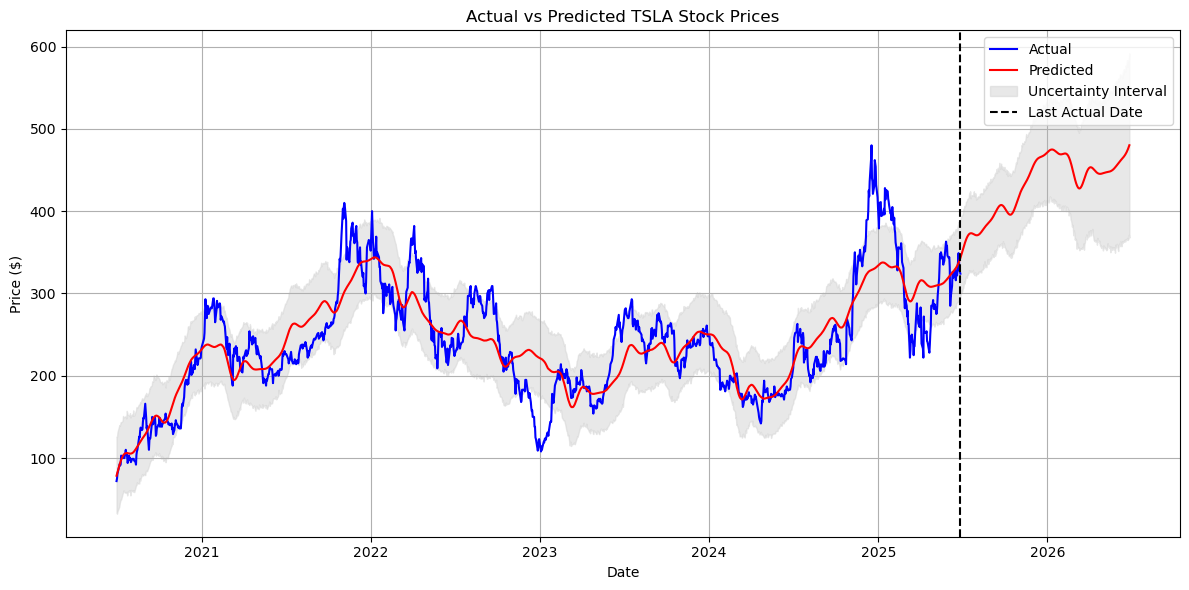

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(merged.index, merged['y_actual'], label='Actual', color='blue')
plt.plot(merged.index, merged['yhat'], label='Predicted', color='red')
plt.fill_between(merged.index, forecast['yhat_lower'], forecast['yhat_upper'], color='lightgray', alpha=0.5, label='Uncertainty Interval')

last_actual_date = merged['y_actual'].dropna().index.max()
plt.axvline(x=last_actual_date, color='black', linestyle='--', label='Last Actual Date')

plt.title('Actual vs Predicted TSLA Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()  
plt.grid(True)
plt.tight_layout()      
plt.show()

As a result we see that Predicted Values are gradually growing, which is not a strong and real indicator for the forecast. 

Let's try to implement  some regressors (Volume, MA7, MA30, MA100, % of Price Change, Volatility) based on the Forecast of a Based Prophet Model for more detailed forecast

In [31]:
yhat_all = forecast[['ds', 'yhat']].copy() #genearate a df from the forecast of a Prophet model

yhat_all['MA7'] = yhat_all['yhat'].rolling(window=7, min_periods=1).mean()
yhat_all['MA30'] = yhat_all['yhat'].rolling(window=30, min_periods=1).mean() 
yhat_all['MA100'] = yhat_all['yhat'].rolling(window=100, min_periods=1).mean() #moving averages for 7, 30 and 100 days   
yhat_all['Return'] = yhat_all['yhat'].pct_change().fillna(0) #shows the percentage change in the stock price from one period to the next
yhat_all['Volatility'] = yhat_all['Return'].rolling(window=30).std().fillna(0) #shows the standard deviation of returns over a 30-day window, indicating the volatility of the stock price

volume_log = np.log1p(df['Volume']).reset_index() #smoothing the Volume data to make it more normally distributed
volume_log.columns = ['ds', 'Volume_log']
yhat_all = yhat_all.merge(volume_log, on='ds', how='left')
yhat_all['Volume_log'] = yhat_all['Volume_log'].fillna(method='ffill')

for reg in ['Return','Volume_log', 'Volatility', 'MA7', 'MA30', 'MA100']:
    yhat_all[reg] = (yhat_all[reg] - yhat_all[reg].mean()) / yhat_all[reg].std() #normalization

df_reg = df_prophet.merge(yhat_all, on='ds', how='left').dropna()

model_reg = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)
for reg in ['Return', 'Volume_log', 'Volatility', 'MA7', 'MA30', 'MA100']:
    model_reg.add_regressor(reg)

model_reg.fit(df_reg)


print(df_reg.tail())


future_reg = yhat_all[['ds', 'Return', 'Volume_log', 'Volatility', 'MA7', 'MA30', 'MA100']]

forecast_reg = model_reg.predict(future_reg)


D:\users\User\AppData\Local\Temp\ipykernel_19620\3567997062.py:12: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

21:23:43 - cmdstanpy - INFO - Chain [1] start processing
21:23:44 - cmdstanpy - INFO - Chain [1] done processing


             ds     y       yhat       MA7      MA30     MA100     Return  \
1250 2020-07-07  93.0  92.748964 -2.069252 -2.049150 -2.017261   2.891138   
1251 2020-07-06  91.0  90.840333 -2.089454 -2.069430 -2.038020  14.256452   
1252 2020-07-02  81.0  82.648487 -2.116443 -2.096523 -2.065755   3.618917   
1253 2020-07-01  75.0  80.553111 -2.127414 -2.107537 -2.077028   3.687445   
1254 2020-06-30  72.0  78.474839 -2.138326 -2.118490 -2.088240  -0.166183   

      Volatility  Volume_log  
1250   -1.377071    3.119782  
1251   -1.377071    3.005903  
1252   -1.377071    2.547711  
1253   -1.377071    1.875983  
1254   -1.377071    2.497178  


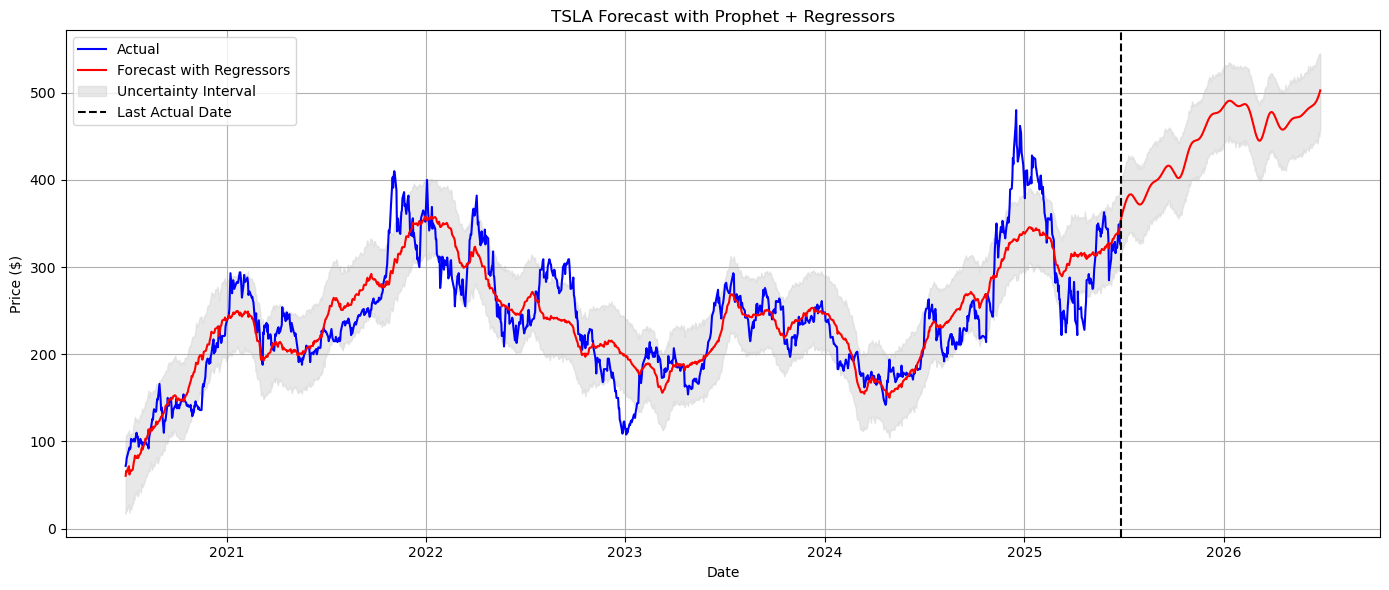

In [32]:
df_actual = df_reg[['ds', 'y']].rename(columns={'y': 'y_actual'})
merged_reg = forecast_reg.set_index('ds').join(df_actual.set_index('ds'), how='left')

plt.figure(figsize=(14, 6))
plt.plot(merged_reg.index, merged_reg['y_actual'], label='Actual', color='blue')
plt.plot(merged.index, merged_reg['yhat'], label='Forecast with Regressors', color='red')
plt.fill_between(merged_reg.index, forecast_reg['yhat_lower'], forecast_reg['yhat_upper'], color='lightgray', alpha=0.5, label='Uncertainty Interval')
plt.axvline(x=merged_reg['y_actual'].dropna().index.max(), color='black', linestyle='--', label='Last Actual Date')
plt.title('TSLA Forecast with Prophet + Regressors')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
df_actual = df_prophet.rename(columns={'y': 'y_actual'}).set_index('ds') #y_actual is the actual values of the stock prices ('Close/Last')
merged_reg = forecast_reg.set_index('ds').join(df_actual, how='left')

validation_reg = merged_reg.dropna(subset=['yhat', 'y_actual']) 

y_actual = validation_reg['y_actual']
y_pred = validation_reg['yhat']

rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f'RMSE: {rmse:.2f}')
mae = mean_absolute_error(y_actual, y_pred)
print(f'MAE: {mae:.2f}')


RMSE: 33.57
MAE: 26.42


As a result, we see that Regressors gave us a better forecast, but still not enough for detailed one. 

Checking correlations

In [34]:
df_feat = df_prophet.copy()

df_feat['MA7'] = df_feat['y'].rolling(window=7, min_periods=1).mean()
df_feat['MA30'] = df_feat['y'].rolling(window=30, min_periods=1).mean()
df_feat['MA100'] = df_feat['y'].rolling(window=100, min_periods=1).mean()
df_feat['Return'] = df_feat['y'].pct_change().fillna(0)
df_feat['Volatility'] = df_feat['Return'].rolling(window=30).std().fillna(0)

volume_log = np.log1p(df['Volume']).reset_index()
volume_log.columns = ['ds', 'Volume_log']
df_feat = df_feat.merge(volume_log, on='ds', how='left')
df_feat['Volume_log'] = df_feat['Volume_log'].ffill()

corrs = df_feat[['y', 'MA7', 'MA30', 'MA100','Return', 'Volatility', 'Volume_log']].corr()
print(corrs['y'].sort_values(ascending=False))

y             1.000000
MA7           0.981793
MA30          0.893562
MA100         0.674846
Return        0.095062
Volatility   -0.085984
Volume_log   -0.381813
Name: y, dtype: float64


Seeing that max_corrs are MA7, MA30, MA100 and max negative corr is Volume_log.

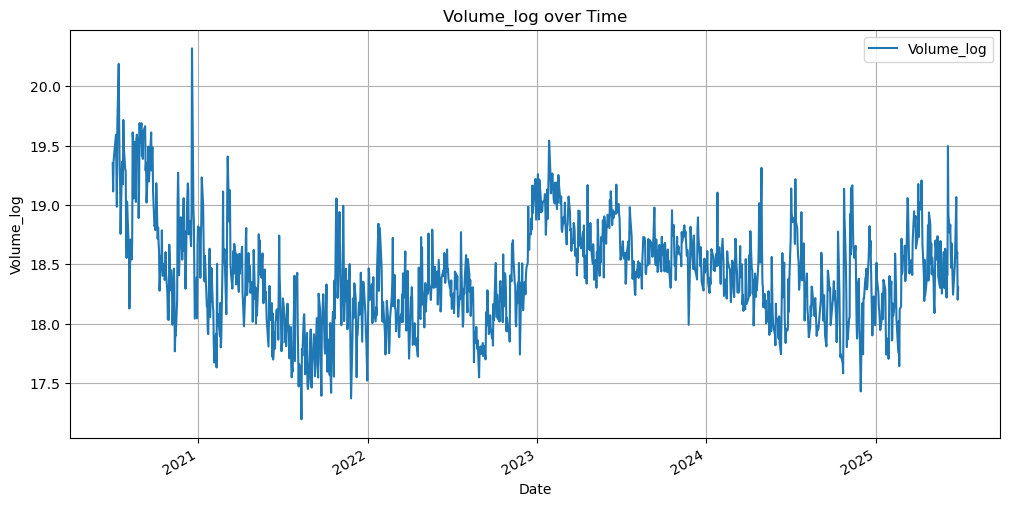

In [35]:
volume_log.plot(x='ds', y='Volume_log', figsize=(12, 6), legend=True, title='Volume_log over Time')
plt.xlabel('Date')
plt.ylabel('Volume_log')
plt.grid(True)
plt.show()

The graphic is not linear, so let's see the p-value to check the stationarity to apply ARIMA model for Volume

In [36]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(volume_log['Volume_log'].dropna())
print(f'p-value: {adf_result[1]}')

p-value: 0.016726724437698987


Applying ARIMA approach for the forecast of Volume

In [37]:
df_reset = df.reset_index()
volume_log = df_reset[['Date', 'Volume']].copy()
volume_log['Volume_log'] = np.log1p(volume_log['Volume'])
volume_log = volume_log.rename(columns={'Date': 'ds'})
volume_log['ds'] = pd.to_datetime(volume_log['ds'])
volume_log = volume_log.sort_values('ds')
volume_series = volume_log.set_index('ds')['Volume_log']


print(volume_series.index[-1])

def arima_forecast(volume_series, periods=365):
    model = auto_arima(volume_series, seasonal=False, stepwise=True, trace=True, error_action='ignore', suppress_warnings=True)
    forecast_values = model.predict(n_periods=periods)
    last_date = volume_series.index[-1]
    future_dates = pd.date_range(start=last_date, periods=periods+1, freq='D')[1:] #create future dates for the forecast starting from the last date in the series
    forecast = pd.DataFrame({'ds': future_dates, 'Volume_log_forecast': forecast_values})

    return forecast

N = len(yhat_all) - len(volume_log)
df_volume_forecast = arima_forecast(volume_series, periods=N)
df_volume_forecast = df_volume_forecast.rename(columns={'Volume_log_forecast': 'Volume_log'})



2025-06-27 00:00:00
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=34.781, Time=1.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=259.682, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=182.537, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=128.330, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=257.694, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=32.821, Time=1.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=55.548, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=30.825, Time=0.74 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=32.821, Time=1.55 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=141.065, Time=0.27 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=29.009, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=126.367, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=180.556, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=31.006, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0]           

In [38]:
print(df.columns)
print(df.index)
print(df.head())


Index(['Close/Last', 'Volume', 'Open', 'High', 'Low', 'SMA_50', 'SMA_100',
       'Month', 'Price_Change', 'Weekday', 'CLose/Last_log'],
      dtype='object')
DatetimeIndex(['2025-06-27', '2025-06-26', '2025-06-25', '2025-06-24',
               '2025-06-23', '2025-06-20', '2025-06-18', '2025-06-17',
               '2025-06-16', '2025-06-13',
               ...
               '2020-07-14', '2020-07-13', '2020-07-10', '2020-07-09',
               '2020-07-08', '2020-07-07', '2020-07-06', '2020-07-02',
               '2020-07-01', '2020-06-30'],
              dtype='datetime64[ns]', name='Date', length=1255, freq=None)
            Close/Last     Volume  Open  High  Low  SMA_50  SMA_100    Month  \
Date                                                                           
2025-06-27       324.0   89067050   325   329  317     NaN      NaN  2025-06   
2025-06-26       326.0   80440910   325   331  324     NaN      NaN  2025-06   
2025-06-25       328.0  119845100   343   343  320     N

The next step is to concatenate Volume from the historical data to the forecast data. And create a Model for forecast 

In [39]:
yhat_all = yhat_all.drop(columns=['Volume_log'], errors='ignore')
volume_full = pd.concat([volume_log[['ds', 'Volume_log']], df_volume_forecast]).drop_duplicates('ds').sort_values('ds').reset_index(drop=True)

yhat_all['ds'] = pd.to_datetime(yhat_all['ds'])
volume_full['ds'] = pd.to_datetime(volume_full['ds'])

yhat_all = yhat_all.merge(volume_full, on='ds', how='left')

#normalization
for reg in ['Return', 'Volume_log', 'Volatility', 'MA7', 'MA30', 'MA100']:
    yhat_all[reg] = (yhat_all[reg] - yhat_all[reg].mean()) / yhat_all[reg].std()

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

df_reg = df_prophet.merge(yhat_all, on='ds', how='left').dropna()

model_reg = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=False)

for reg in ['Return', 'Volume_log', 'Volatility', 'MA7', 'MA30', 'MA100']:
    model_reg.add_regressor(reg)

model_reg.fit(df_reg)
future_reg = yhat_all[['ds', 'Return', 'Volume_log', 'Volatility', 'MA7', 'MA30', 'MA100']]
print(future_reg[future_reg['Volume_log'].isna()])

forecast_reg = model_reg.predict(future_reg)

21:23:54 - cmdstanpy - INFO - Chain [1] start processing
21:23:54 - cmdstanpy - INFO - Chain [1] done processing


Empty DataFrame
Columns: [ds, Return, Volume_log, Volatility, MA7, MA30, MA100]
Index: []


In [40]:
df_actual_full = df_prophet.rename(columns={'y': 'y_actual'}).set_index('ds') #y_actual is the actual values of the stock prices ('Close/Last')
merged_reg = forecast_reg.set_index('ds').join(df_actual_full, how='left')

validation_reg = merged_reg.dropna(subset=['yhat', 'y_actual']) 

y_actual = validation_reg['y_actual']
y_pred = validation_reg['yhat']

rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f'RMSE: {rmse:.2f}')
mae = mean_absolute_error(y_actual, y_pred)
print(f'MAE: {mae:.2f}')

RMSE: 33.64
MAE: 26.49


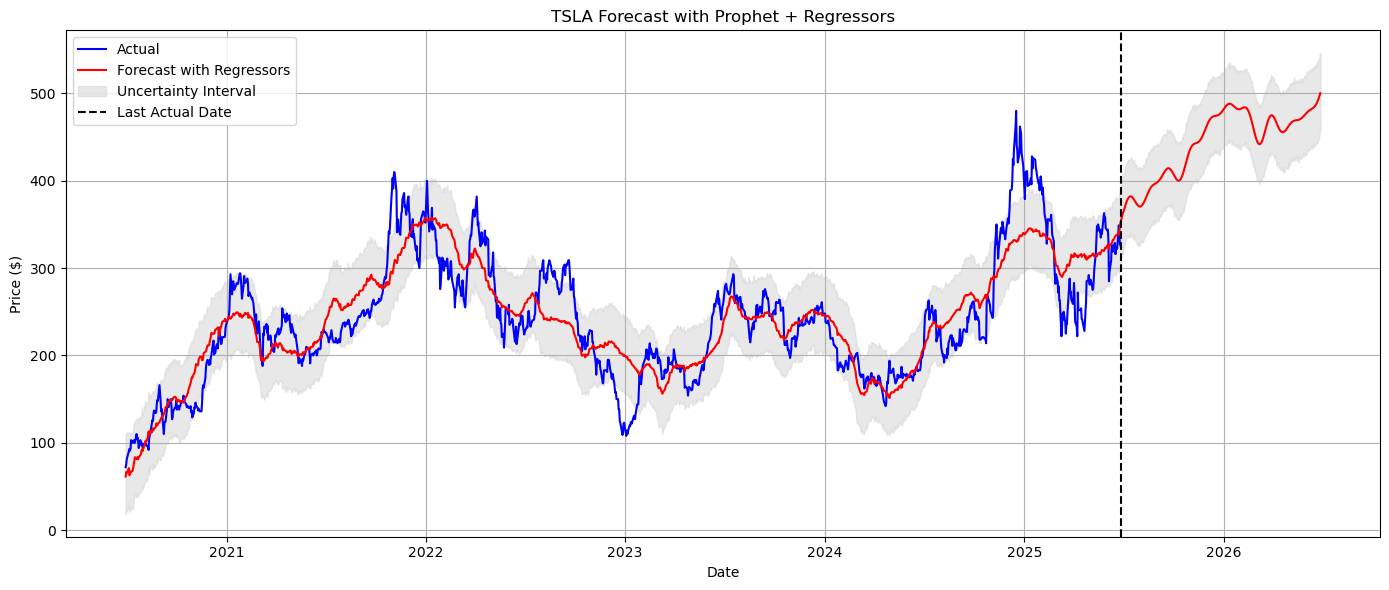

In [41]:
plt.figure(figsize=(14, 6))
plt.plot(merged_reg.index, merged_reg['y_actual'], label='Actual', color='blue')
plt.plot(merged.index, merged_reg['yhat'], label='Forecast with Regressors', color='red')
plt.fill_between(merged_reg.index, forecast_reg['yhat_lower'], forecast_reg['yhat_upper'], color='lightgray', alpha=0.5, label='Uncertainty Interval')
plt.axvline(x=validation_reg.index.max(), color='black', linestyle='--', label='Last Actual Date')
plt.title('TSLA Forecast with Prophet + Regressors')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
df_TSLA_2026 = forecast_reg[forecast_reg['ds'].dt.year == 2026][['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
df_TSLA_2026.rename(columns={'yhat': 'forecasted_price'}, inplace=True)
df_TSLA_2026.head()

,ds,forecasted_price,yhat_lower,yhat_upper
1442,2026-01-01,481.914543,439.737805,522.688985
1443,2026-01-02,482.828310,440.094034,526.883930
1444,2026-01-03,483.723309,441.534800,529.708218
1445,2026-01-04,484.580432,440.939570,527.479584
1446,2026-01-05,485.381192,441.037538,527.426326


In [43]:
df_TSLA_2026.to_csv('TSLA_forecast_2026.csv', index=False)